In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
import scipy.stats as stats
from sklearn import feature_selection
#import scikit_posthocs as sp
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")

sns.set_theme(style="white")

This notebook is used to perform various statistical tests to select the most optimal synthesis parameters for further use in machine learning models.

In [2]:
df = pd.read_excel('../Datasets/dataset_labeled.xlsx')

In [3]:
df

Image_id  Ca ion, mM  CO3 ion, mM  HCO3 ion, mM  Polymer Mwt, kDa  \
0           0          81           22             0              40.0   
1           1         133           22           240               3.0   
2           2          69          203             0               2.1   
3           3          50           46            31            1000.0   
4           4         179            0           280              25.0   
..        ...         ...          ...           ...               ...   
204       210          68            0           240               0.0   
205       211         177          219            31               0.0   
206       212         216           78            62               0.0   
207       213          27           87             0               0.0   
208       214          21            0            66               0.0   

     Polymer, % wt.  Surfactant, % wt.  Solvent, % vol.  Stirring, rpm  \
0             0.335              0.425              0.0              0   
1             0.375              0.000              0.0              0   
2             0.395              0.000              0.0            770   
3             0.320              0.000              0.0              0   
4             0.875              0.000              0.0              0   
..              ...                ...              ...            ...   
204           0.000              0.000              0.0            820   
205           0.000              0.000              0.0            820   
206           0.000              0.000              0.0            620   
207           0.000              0.000              0.0            620   
208           0.000              0.000              0.0            620   

     Temperature, C  ...  Sphere_max  Flat_min  Flat_max  Amorphous_min  \
0                58  ...           0         0         0              0   
1                68  ...           0         0         0              0   
2                76  ...          22         0         0              0   
3                58  ...          17         0         0              0   
4                68  ...           0         0         0              0   
..              ...  ...         ...       ...       ...            ...   
204              35  ...           0         0         0              0   
205              35  ...           0         0         0             24   
206              68  ...           0         0         0              0   
207              68  ...           0         0         0              0   
208              68  ...           0         0         0              0   

     Amorphous_max  Cube  Stick  Sphere  Flat  Amorphous  
0                0     1      1       0     0          0  
1                0     0      1       0     0          0  
2                0     0      0       1     0          0  
3                0     1      0       1     0          0  
4                0     1      1       0     0          0  
..             ...   ...    ...     ...   ...        ...  
204              0     1      0       0     0          0  
205             79     1      0       0     0          1  
206              0     1      1       0     0          0  
207              0     1      1       0     0          0  
208              0     1      1       0     0          0  

[209 rows x 45 columns]

In [4]:
df = df.drop(columns=['Image_id'])

In [5]:
num_cols = df.iloc[:, :10].columns

In [6]:
df_cat_label = df.loc[: , 'Hexadecyltrimethylammonium bromide': 'PVP']

The minimum and maximum sizes of nanoparticles of each shape were used in labeling the dataset. To determine the average particle size for each synthesis, the average between these two parameters was found.

In [7]:
df['Cube_avg'] = df.loc[:,['Cube_min', 'Cube_max']].mean(axis=1)
df['Stick_avg'] = df.loc[:,['Stick_min', 'Stick_max']].mean(axis=1)
df['Sphere_avg'] = df.loc[:,['Sphere_min', 'Sphere_max']].mean(axis=1)
df['Flat_avg'] = df.loc[:,['Flat_min', 'Flat_max']].mean(axis=1)
df['Amorphous_avg'] = df.loc[:,['Amorphous_min', 'Amorphous_max']].mean(axis=1)

Next, pipelines with various statistical tests were applied for nanoparticles of each shape to determine the most optimal numerical and categorical parameters. The results of the tests are also summarized below. As a result, those parameters that were found to be the least important were excluded, e.g., stirring speed,
concentrations of Ca and CO3 ions, presence of Hexadecyltrimethylammonium bromide and Triton X-100 surfactants, and 1-Hexanol and Methyl alcohol solvents. 

The use of these tests is described in the article under Feature selection, and in the Supplementary materials in Section D. A brief summary table of the test results is provided in Supplementary materials in Section E.

### Multitest pipeline categorical

#### Functions

In [8]:
def continious_test(particle, column):
    results = []
    p = feature_selection.chi2(np.array(df[column]).reshape(-1, 1), df[particle])[1]
    if p <= 0.05 / 5:
        results.append("✓")
    else:
        results.append("x")
    if p <= 0.1 / 5:
        results.append("✓")
    else:
        results.append("x")
    data = [
        [
            209 - df[df[particle] == 0][column].sum(),
            df[df[particle] == 0][column].sum(),
            
            
        ],
        [
            209 - df[df[particle] == 1][column].sum(),
            df[df[particle] == 1][column].sum(),
            
        ],
    ]
    odd_ratio, p = stats.fisher_exact(data)
    if p <= 0.05 / 5:
        results.append("✓")
    else:
        results.append("x")
    if p <= 0.1 / 5:
        results.append("✓")
    else:
        results.append("x")

    results.append(
        mutual_info_classif(
            df[column].to_frame(), df[particle], discrete_features=[True]
        ).round(3)[0]
    )
    results.append(stats.pearsonr(df[column], df[particle])[0].round(3))
    results.append(stats.spearmanr(df[column], df[particle])[0].round(3))
    return results


def multitest_pipeline(shape):
    arrays = [
        np.array(
            [
                "Does target column depend on shape column?",
                "Does target column depend on shape column?",
                "Does target column depend on shape column?",
                "Does target column depend on shape column?",
                "MI between shape column and target column",
                "Correlation coefficients",
                "Correlation coefficients",
            ]
        ),
        np.array(
            [
                "Chi-squared test",
                "Chi-squared test",
                "Fisher’s Exact Test",
                "Fisher’s Exact Test",
                "Mutual Information",
                "Pearson correlation",
                "Spearman's rank correlation",
            ]
        ),
    ]
    tuples = list(zip(*arrays))
    index = pd.MultiIndex.from_tuples(tuples, names=["description", "test"])
    results_df = pd.concat(
        [
            pd.DataFrame(
                {
                    "alpha": ["0.05 / 5", "0.1 / 5", "0.05 / 5", "0.1 / 5", "", "", ""],
                },
                index=index,
            ),
            pd.DataFrame(
                {
                    column: continious_test(shape, column)
                    for column in df_cat_label.columns
                },
                index=index,
            ),
        ],
        axis=1,
    )
    return results_df

#### Results

In [9]:
multitest_pipeline('Cube').T

description                        Does target column depend on shape column?  \
test                                                         Chi-squared test   
alpha                                                                0.05 / 5   
Hexadecyltrimethylammonium bromide                                          x   
Myristyltrimethylammonium bromide                                           x   
No_surfactant                                                               x   
Sodium dodecylsulfate                                                       ✓   
Triton X-100                                                                x   
1-Hexanol                                                                   x   
Dimethylformamide                                                           x   
Ethylene glycol                                                             x   
Isopropyl alcohol                                                           x   
Methyl alcohol                                                              x   
No_solvent                                                                  x   
Propylene glycol                                                            x   
tert-Butanol                                                                x   
No_polymer                                                                  ✓   
PAA                                                                         ✓   
PEG                                                                         x   
PEI                                                                         x   
PSS                                                                         ✓   
PVP                                                                         x   

description                                                              \
test                               Chi-squared test Fisher’s Exact Test   
alpha                                       0.1 / 5            0.05 / 5   
Hexadecyltrimethylammonium bromide                x                   x   
Myristyltrimethylammonium bromide                 x                   ✓   
No_surfactant                                     x                   ✓   
Sodium dodecylsulfate                             ✓                   x   
Triton X-100                                      x                   x   
1-Hexanol                                         x                   x   
Dimethylformamide                                 x                   x   
Ethylene glycol                                   x                   x   
Isopropyl alcohol                                 x                   x   
Methyl alcohol                                    x                   x   
No_solvent                                        x                   ✓   
Propylene glycol                                  x                   x   
tert-Butanol                                      x                   x   
No_polymer                                        ✓                   ✓   
PAA                                               ✓                   ✓   
PEG                                               x                   x   
PEI                                               x                   x   
PSS                                               ✓                   x   
PVP                                               x                   x   

description                                             \
test                               Fisher’s Exact Test   
alpha                                          0.1 / 5   
Hexadecyltrimethylammonium bromide                   x   
Myristyltrimethylammonium bromide                    ✓   
No_surfactant                                        ✓   
Sodium dodecylsulfate                                ✓   
Triton X-100                                         x   
1-Hexanol                                            x   
Dimethylformamide                           

In [10]:
multitest_pipeline('Sphere').T

description                        Does target column depend on shape column?  \
test                                                         Chi-squared test   
alpha                                                                0.05 / 5   
Hexadecyltrimethylammonium bromide                                          x   
Myristyltrimethylammonium bromide                                           ✓   
No_surfactant                                                               x   
Sodium dodecylsulfate                                                       x   
Triton X-100                                                                x   
1-Hexanol                                                                   x   
Dimethylformamide                                                           x   
Ethylene glycol                                                             x   
Isopropyl alcohol                                                           x   
Methyl alcohol                                                              x   
No_solvent                                                                  x   
Propylene glycol                                                            x   
tert-Butanol                                                                x   
No_polymer                                                                  x   
PAA                                                                         x   
PEG                                                                         x   
PEI                                                                         x   
PSS                                                                         x   
PVP                                                                         x   

description                                                              \
test                               Chi-squared test Fisher’s Exact Test   
alpha                                       0.1 / 5            0.05 / 5   
Hexadecyltrimethylammonium bromide                x                   ✓   
Myristyltrimethylammonium bromide                 ✓                   x   
No_surfactant                                     x                   ✓   
Sodium dodecylsulfate                             x                   x   
Triton X-100                                      x                   x   
1-Hexanol                                         x                   x   
Dimethylformamide                                 x                   x   
Ethylene glycol                                   x                   x   
Isopropyl alcohol                                 x                   ✓   
Methyl alcohol                                    x                   ✓   
No_solvent                                        x                   ✓   
Propylene glycol                                  x                   x   
tert-Butanol                                      x                   x   
No_polymer                                        x                   ✓   
PAA                                               x                   x   
PEG                                               x                   ✓   
PEI                                               x                   ✓   
PSS                                               x                   x   
PVP                                               x                   ✓   

description                                             \
test                               Fisher’s Exact Test   
alpha                                          0.1 / 5   
Hexadecyltrimethylammonium bromide                   ✓   
Myristyltrimethylammonium bromide                    x   
No_surfactant                                        ✓   
Sodium dodecylsulfate                                ✓   
Triton X-100                                         x   
1-Hexanol                                            x   
Dimethylformamide                           

In [11]:
multitest_pipeline('Stick').T

description                        Does target column depend on shape column?  \
test                                                         Chi-squared test   
alpha                                                                0.05 / 5   
Hexadecyltrimethylammonium bromide                                          x   
Myristyltrimethylammonium bromide                                           x   
No_surfactant                                                               x   
Sodium dodecylsulfate                                                       ✓   
Triton X-100                                                                x   
1-Hexanol                                                                   x   
Dimethylformamide                                                           x   
Ethylene glycol                                                             x   
Isopropyl alcohol                                                           x   
Methyl alcohol                                                              x   
No_solvent                                                                  x   
Propylene glycol                                                            x   
tert-Butanol                                                                x   
No_polymer                                                                  x   
PAA                                                                         x   
PEG                                                                         ✓   
PEI                                                                         ✓   
PSS                                                                         x   
PVP                                                                         x   

description                                                              \
test                               Chi-squared test Fisher’s Exact Test   
alpha                                       0.1 / 5            0.05 / 5   
Hexadecyltrimethylammonium bromide                x                   x   
Myristyltrimethylammonium bromide                 x                   x   
No_surfactant                                     x                   x   
Sodium dodecylsulfate                             ✓                   ✓   
Triton X-100                                      x                   x   
1-Hexanol                                         x                   x   
Dimethylformamide                                 x                   x   
Ethylene glycol                                   x                   x   
Isopropyl alcohol                                 x                   x   
Methyl alcohol                                    x                   x   
No_solvent                                        x                   x   
Propylene glycol                                  x                   x   
tert-Butanol                                      x                   x   
No_polymer                                        x                   ✓   
PAA                                               ✓                   ✓   
PEG                                               ✓                   x   
PEI                                               ✓                   x   
PSS                                               x                   x   
PVP                                               x                   x   

description                                             \
test                               Fisher’s Exact Test   
alpha                                          0.1 / 5   
Hexadecyltrimethylammonium bromide                   x   
Myristyltrimethylammonium bromide                    x   
No_surfactant                                        x   
Sodium dodecylsulfate                                ✓   
Triton X-100                                         x   
1-Hexanol                                            x   
Dimethylformamide                           

In [12]:
multitest_pipeline('Flat').T

description                        Does target column depend on shape column?  \
test                                                         Chi-squared test   
alpha                                                                0.05 / 5   
Hexadecyltrimethylammonium bromide                                          x   
Myristyltrimethylammonium bromide                                           x   
No_surfactant                                                               x   
Sodium dodecylsulfate                                                       x   
Triton X-100                                                                x   
1-Hexanol                                                                   x   
Dimethylformamide                                                           x   
Ethylene glycol                                                             x   
Isopropyl alcohol                                                           x   
Methyl alcohol                                                              x   
No_solvent                                                                  x   
Propylene glycol                                                            x   
tert-Butanol                                                                x   
No_polymer                                                                  x   
PAA                                                                         ✓   
PEG                                                                         x   
PEI                                                                         x   
PSS                                                                         x   
PVP                                                                         x   

description                                                              \
test                               Chi-squared test Fisher’s Exact Test   
alpha                                       0.1 / 5            0.05 / 5   
Hexadecyltrimethylammonium bromide                x                   x   
Myristyltrimethylammonium bromide                 x                   ✓   
No_surfactant                                     x                   ✓   
Sodium dodecylsulfate                             x                   ✓   
Triton X-100                                      x                   x   
1-Hexanol                                         x                   ✓   
Dimethylformamide                                 x                   ✓   
Ethylene glycol                                   x                   x   
Isopropyl alcohol                                 x                   x   
Methyl alcohol                                    x                   ✓   
No_solvent                                        x                   ✓   
Propylene glycol                                  x                   ✓   
tert-Butanol                                      x                   ✓   
No_polymer                                        x                   ✓   
PAA                                               ✓                   x   
PEG                                               x                   ✓   
PEI                                               x                   ✓   
PSS                                               x                   ✓   
PVP                                               x                   ✓   

description                                             \
test                               Fisher’s Exact Test   
alpha                                          0.1 / 5   
Hexadecyltrimethylammonium bromide                   x   
Myristyltrimethylammonium bromide                    ✓   
No_surfactant                                        ✓   
Sodium dodecylsulfate                                ✓   
Triton X-100                                         x   
1-Hexanol                                            ✓   
Dimethylformamide                           

In [13]:
multitest_pipeline('Amorphous').T

description                        Does target column depend on shape column?  \
test                                                         Chi-squared test   
alpha                                                                0.05 / 5   
Hexadecyltrimethylammonium bromide                                          x   
Myristyltrimethylammonium bromide                                           x   
No_surfactant                                                               x   
Sodium dodecylsulfate                                                       ✓   
Triton X-100                                                                x   
1-Hexanol                                                                   x   
Dimethylformamide                                                           x   
Ethylene glycol                                                             x   
Isopropyl alcohol                                                           ✓   
Methyl alcohol                                                              x   
No_solvent                                                                  x   
Propylene glycol                                                            x   
tert-Butanol                                                                x   
No_polymer                                                                  x   
PAA                                                                         x   
PEG                                                                         x   
PEI                                                                         x   
PSS                                                                         x   
PVP                                                                         x   

description                                                              \
test                               Chi-squared test Fisher’s Exact Test   
alpha                                       0.1 / 5            0.05 / 5   
Hexadecyltrimethylammonium bromide                x                   x   
Myristyltrimethylammonium bromide                 x                   ✓   
No_surfactant                                     x                   ✓   
Sodium dodecylsulfate                             ✓                   x   
Triton X-100                                      x                   x   
1-Hexanol                                         x                   ✓   
Dimethylformamide                                 x                   ✓   
Ethylene glycol                                   x                   ✓   
Isopropyl alcohol                                 ✓                   x   
Methyl alcohol                                    x                   x   
No_solvent                                        x                   ✓   
Propylene glycol                                  x                   ✓   
tert-Butanol                                      x                   ✓   
No_polymer                                        x                   ✓   
PAA                                               x                   x   
PEG                                               x                   ✓   
PEI                                               x                   ✓   
PSS                                               x                   x   
PVP                                               x                   ✓   

description                                             \
test                               Fisher’s Exact Test   
alpha                                          0.1 / 5   
Hexadecyltrimethylammonium bromide                   x   
Myristyltrimethylammonium bromide                    ✓   
No_surfactant                                        ✓   
Sodium dodecylsulfate                                x   
Triton X-100                                         x   
1-Hexanol                                            ✓   
Dimethylformamide                           

### Multitest pipeline numerical

#### Functions

In [14]:
def continious_test(particle, column):
    results = []
    _, p = stats.mannwhitneyu(df[df[particle] == 0][column], df[df[particle] == 1][column])
    if p <= 0.05 / 5:
        results.append('✓')
    else:
        results.append('x')
    if p <= 0.1 / 5:
        results.append('✓')
    else:
        results.append('x')
    _, p = stats.kruskal(df[df[particle] == 0][column], df[df[particle] == 1][column])
    if p <= 0.05 / 5:
        results.append('✓')
    else:
        results.append('x')
    if p <= 0.1 / 5:
        results.append('✓')
    else:
        results.append('x')
    _, p = stats.kstest(df[df[particle] == 0][column], df[df[particle] == 1][column])
    if p <= 0.05 / 5:
        results.append('✓')
    else:
        results.append('x')
    if p <= 0.1 / 5:
        results.append('✓')
    else:
        results.append('x')
    p = feature_selection.f_classif(np.array(df[column]).reshape(-1, 1), df[particle])[1]
    if p <= 0.05 / 5:
        results.append('✓')
    else:
        results.append('x')
    if p <= 0.1 / 5:
        results.append('✓')
    else:
        results.append('x')
    results.append(mutual_info_classif(df[column].to_frame(), df[particle], discrete_features=[False]).round(3)[0])
    results.append(stats.pearsonr(df[column], df[particle])[0].round(3))
    results.append(stats.spearmanr(df[column], df[particle])[0].round(3))
    return results

def multitest_pipeline(shape):
    arrays = [
        np.array(
            [
                "Are distributions with and without this partcile different?",
                "Are distributions with and without this partcile different?",
                "Are distributions with and without this partcile different?",
                "Are distributions with and without this partcile different?",
                "Are distributions with and without this partcile different?",
                "Are distributions with and without this partcile different?",
                "Does target column depend on shape column?",
                "Does target column depend on shape column?",
                "MI between shape column and target column",
                "Correlation coefficients",
                "Correlation coefficients",
            ]
        ),
        np.array(
            [
                "Mann–Whitney U test",
                "Mann–Whitney U test",
                "Kruskal–Wallis H",
                "Kruskal–Wallis H",
                "Kolmogorov–Smirnov",
                "Kolmogorov–Smirnov",
                "ANOVA",
                "ANOVA",
                "Mutual Information",
                "Pearson correlation",
                "Spearman's rank correlation",
            ]
        ),
    ]
    tuples = list(zip(*arrays))
    index = pd.MultiIndex.from_tuples(tuples, names=["description", "test"])
    results_df = pd.concat([pd.DataFrame(
        {
            "alpha": ['0.05 / n', '0.1 / n', '0.05 / n', '0.1 / n', '0.05 / n', '0.1 / n', '0.05 / n', '0.1 / n', "", "", ""],
        }, index = index
    ), 
    pd.DataFrame(
        {column: continious_test(shape, column) for column in num_cols 
        }, index = index
    )], axis=1)
    return results_df

#### Results

In [15]:
multitest_pipeline('Cube')

alpha  \
description                                        test                                    
Are distributions with and without this partcil... Mann–Whitney U test          0.05 / n   
                                                   Mann–Whitney U test           0.1 / n   
                                                   Kruskal–Wallis H             0.05 / n   
                                                   Kruskal–Wallis H              0.1 / n   
                                                   Kolmogorov–Smirnov           0.05 / n   
                                                   Kolmogorov–Smirnov            0.1 / n   
Does target column depend on shape column?         ANOVA                        0.05 / n   
                                                   ANOVA                         0.1 / n   
MI between shape column and target column          Mutual Information                      
Correlation coefficients                           Pearson correlation                     
                                                   Spearman's rank correlation             

                                                                               Ca ion, mM  \
description                                        test                                     
Are distributions with and without this partcil... Mann–Whitney U test                  x   
                                                   Mann–Whitney U test                  x   
                                                   Kruskal–Wallis H                     x   
                                                   Kruskal–Wallis H                     x   
                                                   Kolmogorov–Smirnov                   x   
                                                   Kolmogorov–Smirnov                   x   
Does target column depend on shape column?         ANOVA                                x   
                                                   ANOVA                                x   
MI between shape column and target column          Mutual Information               0.002   
Correlation coefficients                           Pearson correlation              -0.06   
                                                   Spearman's rank correlation     -0.082   

                                                                               CO3 ion, mM  \
description                                        test                                      
Are distributions with and without this partcil... Mann–Whitney U test                   x   
                                                   Mann–Whitney U test                   x   
                                                   Kruskal–Wallis H                      x   
                                                   Kruskal–Wallis H                      x   
                                                   Kolmogorov–Smirnov                    x   
                                                   Kolmogorov–Smirnov                    x   
Does target column depend on shape column?         ANOVA                                 x   
                                                   ANOVA                                 x   
MI between shape column and target column          Mutual Information                    0   
Correlation coefficients                           Pearson correlation              -0.042   
                                                   Spearman's rank correlation      -0.056   

                                                                               HCO3 ion, mM  \
description                                        test                                       
Are distributions with and without this partcil... Mann–Whitney U test                    x   
                                                   Mann–Whitney U test                    x   
                                                   Kruskal–Wallis H      

In [16]:
multitest_pipeline('Sphere')

alpha  \
description                                        test                                    
Are distributions with and without this partcil... Mann–Whitney U test          0.05 / n   
                                                   Mann–Whitney U test           0.1 / n   
                                                   Kruskal–Wallis H             0.05 / n   
                                                   Kruskal–Wallis H              0.1 / n   
                                                   Kolmogorov–Smirnov           0.05 / n   
                                                   Kolmogorov–Smirnov            0.1 / n   
Does target column depend on shape column?         ANOVA                        0.05 / n   
                                                   ANOVA                         0.1 / n   
MI between shape column and target column          Mutual Information                      
Correlation coefficients                           Pearson correlation                     
                                                   Spearman's rank correlation             

                                                                               Ca ion, mM  \
description                                        test                                     
Are distributions with and without this partcil... Mann–Whitney U test                  x   
                                                   Mann–Whitney U test                  x   
                                                   Kruskal–Wallis H                     x   
                                                   Kruskal–Wallis H                     x   
                                                   Kolmogorov–Smirnov                   x   
                                                   Kolmogorov–Smirnov                   x   
Does target column depend on shape column?         ANOVA                                x   
                                                   ANOVA                                x   
MI between shape column and target column          Mutual Information                   0   
Correlation coefficients                           Pearson correlation               0.01   
                                                   Spearman's rank correlation      0.008   

                                                                               CO3 ion, mM  \
description                                        test                                      
Are distributions with and without this partcil... Mann–Whitney U test                   x   
                                                   Mann–Whitney U test                   x   
                                                   Kruskal–Wallis H                      x   
                                                   Kruskal–Wallis H                      x   
                                                   Kolmogorov–Smirnov                    x   
                                                   Kolmogorov–Smirnov                    x   
Does target column depend on shape column?         ANOVA                                 x   
                                                   ANOVA                                 x   
MI between shape column and target column          Mutual Information                    0   
Correlation coefficients                           Pearson correlation                0.09   
                                                   Spearman's rank correlation       0.059   

                                                                               HCO3 ion, mM  \
description                                        test                                       
Are distributions with and without this partcil... Mann–Whitney U test                    x   
                                                   Mann–Whitney U test                    ✓   
                                                   Kruskal–Wallis H      

In [17]:
multitest_pipeline('Stick')

alpha  \
description                                        test                                    
Are distributions with and without this partcil... Mann–Whitney U test          0.05 / n   
                                                   Mann–Whitney U test           0.1 / n   
                                                   Kruskal–Wallis H             0.05 / n   
                                                   Kruskal–Wallis H              0.1 / n   
                                                   Kolmogorov–Smirnov           0.05 / n   
                                                   Kolmogorov–Smirnov            0.1 / n   
Does target column depend on shape column?         ANOVA                        0.05 / n   
                                                   ANOVA                         0.1 / n   
MI between shape column and target column          Mutual Information                      
Correlation coefficients                           Pearson correlation                     
                                                   Spearman's rank correlation             

                                                                               Ca ion, mM  \
description                                        test                                     
Are distributions with and without this partcil... Mann–Whitney U test                  x   
                                                   Mann–Whitney U test                  x   
                                                   Kruskal–Wallis H                     x   
                                                   Kruskal–Wallis H                     x   
                                                   Kolmogorov–Smirnov                   x   
                                                   Kolmogorov–Smirnov                   x   
Does target column depend on shape column?         ANOVA                                x   
                                                   ANOVA                                x   
MI between shape column and target column          Mutual Information                   0   
Correlation coefficients                           Pearson correlation             -0.004   
                                                   Spearman's rank correlation     -0.029   

                                                                               CO3 ion, mM  \
description                                        test                                      
Are distributions with and without this partcil... Mann–Whitney U test                   x   
                                                   Mann–Whitney U test                   x   
                                                   Kruskal–Wallis H                      x   
                                                   Kruskal–Wallis H                      x   
                                                   Kolmogorov–Smirnov                    x   
                                                   Kolmogorov–Smirnov                    x   
Does target column depend on shape column?         ANOVA                                 x   
                                                   ANOVA                                 x   
MI between shape column and target column          Mutual Information                    0   
Correlation coefficients                           Pearson correlation               0.079   
                                                   Spearman's rank correlation       0.129   

                                                                               HCO3 ion, mM  \
description                                        test                                       
Are distributions with and without this partcil... Mann–Whitney U test                    x   
                                                   Mann–Whitney U test                    x   
                                                   Kruskal–Wallis H      

In [18]:
multitest_pipeline('Flat')

alpha  \
description                                        test                                    
Are distributions with and without this partcil... Mann–Whitney U test          0.05 / n   
                                                   Mann–Whitney U test           0.1 / n   
                                                   Kruskal–Wallis H             0.05 / n   
                                                   Kruskal–Wallis H              0.1 / n   
                                                   Kolmogorov–Smirnov           0.05 / n   
                                                   Kolmogorov–Smirnov            0.1 / n   
Does target column depend on shape column?         ANOVA                        0.05 / n   
                                                   ANOVA                         0.1 / n   
MI between shape column and target column          Mutual Information                      
Correlation coefficients                           Pearson correlation                     
                                                   Spearman's rank correlation             

                                                                               Ca ion, mM  \
description                                        test                                     
Are distributions with and without this partcil... Mann–Whitney U test                  x   
                                                   Mann–Whitney U test                  x   
                                                   Kruskal–Wallis H                     x   
                                                   Kruskal–Wallis H                     x   
                                                   Kolmogorov–Smirnov                   x   
                                                   Kolmogorov–Smirnov                   x   
Does target column depend on shape column?         ANOVA                                x   
                                                   ANOVA                                x   
MI between shape column and target column          Mutual Information               0.011   
Correlation coefficients                           Pearson correlation              0.118   
                                                   Spearman's rank correlation      0.119   

                                                                               CO3 ion, mM  \
description                                        test                                      
Are distributions with and without this partcil... Mann–Whitney U test                   x   
                                                   Mann–Whitney U test                   x   
                                                   Kruskal–Wallis H                      x   
                                                   Kruskal–Wallis H                      x   
                                                   Kolmogorov–Smirnov                    x   
                                                   Kolmogorov–Smirnov                    x   
Does target column depend on shape column?         ANOVA                                 x   
                                                   ANOVA                                 x   
MI between shape column and target column          Mutual Information                0.007   
Correlation coefficients                           Pearson correlation               -0.02   
                                                   Spearman's rank correlation      -0.065   

                                                                               HCO3 ion, mM  \
description                                        test                                       
Are distributions with and without this partcil... Mann–Whitney U test                    x   
                                                   Mann–Whitney U test                    x   
                                                   Kruskal–Wallis H      

In [19]:
multitest_pipeline('Amorphous')

alpha  \
description                                        test                                    
Are distributions with and without this partcil... Mann–Whitney U test          0.05 / n   
                                                   Mann–Whitney U test           0.1 / n   
                                                   Kruskal–Wallis H             0.05 / n   
                                                   Kruskal–Wallis H              0.1 / n   
                                                   Kolmogorov–Smirnov           0.05 / n   
                                                   Kolmogorov–Smirnov            0.1 / n   
Does target column depend on shape column?         ANOVA                        0.05 / n   
                                                   ANOVA                         0.1 / n   
MI between shape column and target column          Mutual Information                      
Correlation coefficients                           Pearson correlation                     
                                                   Spearman's rank correlation             

                                                                               Ca ion, mM  \
description                                        test                                     
Are distributions with and without this partcil... Mann–Whitney U test                  x   
                                                   Mann–Whitney U test                  x   
                                                   Kruskal–Wallis H                     x   
                                                   Kruskal–Wallis H                     x   
                                                   Kolmogorov–Smirnov                   x   
                                                   Kolmogorov–Smirnov                   x   
Does target column depend on shape column?         ANOVA                                x   
                                                   ANOVA                                x   
MI between shape column and target column          Mutual Information                   0   
Correlation coefficients                           Pearson correlation              0.005   
                                                   Spearman's rank correlation      0.067   

                                                                               CO3 ion, mM  \
description                                        test                                      
Are distributions with and without this partcil... Mann–Whitney U test                   x   
                                                   Mann–Whitney U test                   x   
                                                   Kruskal–Wallis H                      x   
                                                   Kruskal–Wallis H                      x   
                                                   Kolmogorov–Smirnov                    x   
                                                   Kolmogorov–Smirnov                    x   
Does target column depend on shape column?         ANOVA                                 x   
                                                   ANOVA                                 x   
MI between shape column and target column          Mutual Information                    0   
Correlation coefficients                           Pearson correlation               0.106   
                                                   Spearman's rank correlation       0.112   

                                                                               HCO3 ion, mM  \
description                                        test                                       
Are distributions with and without this partcil... Mann–Whitney U test                    x   
                                                   Mann–Whitney U test                    x   
                                                   Kruskal–Wallis H      

### Correlations

In [20]:
# Compute the correlation matrix
corr = df.corr(method='pearson')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

<Axes: >

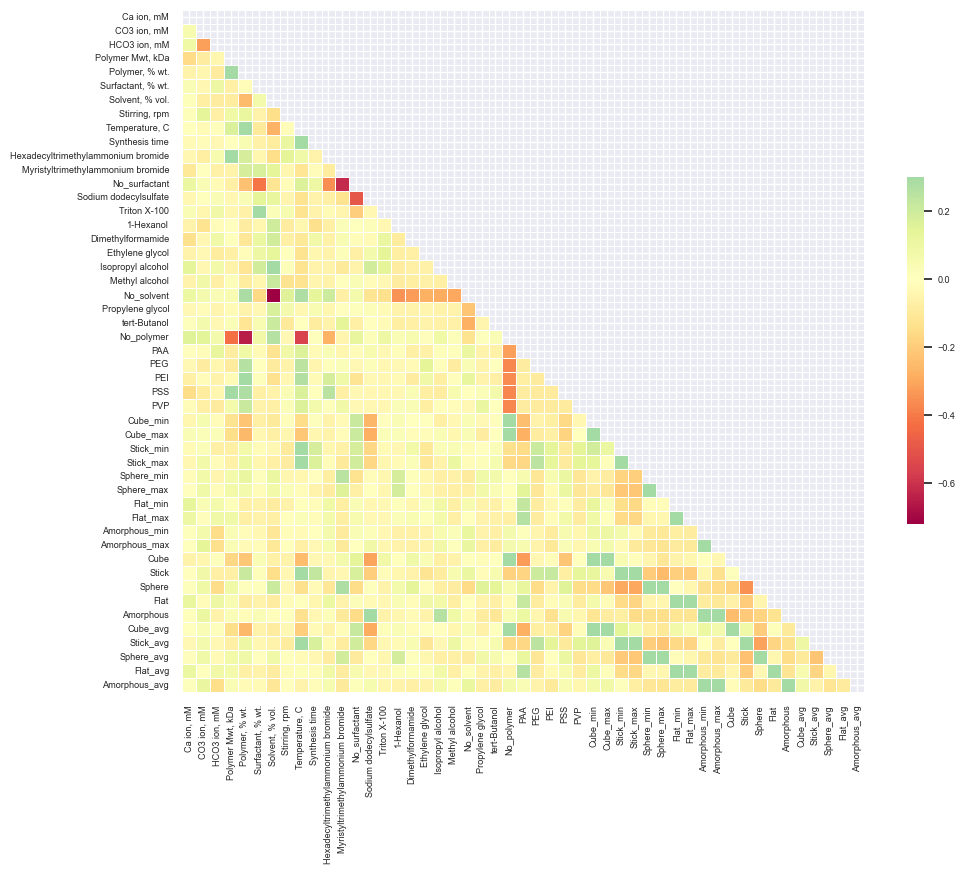

In [21]:
sns.set(font_scale=0.6)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='Spectral', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [22]:
# Compute the correlation matrix
corr = df.corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

<Axes: >

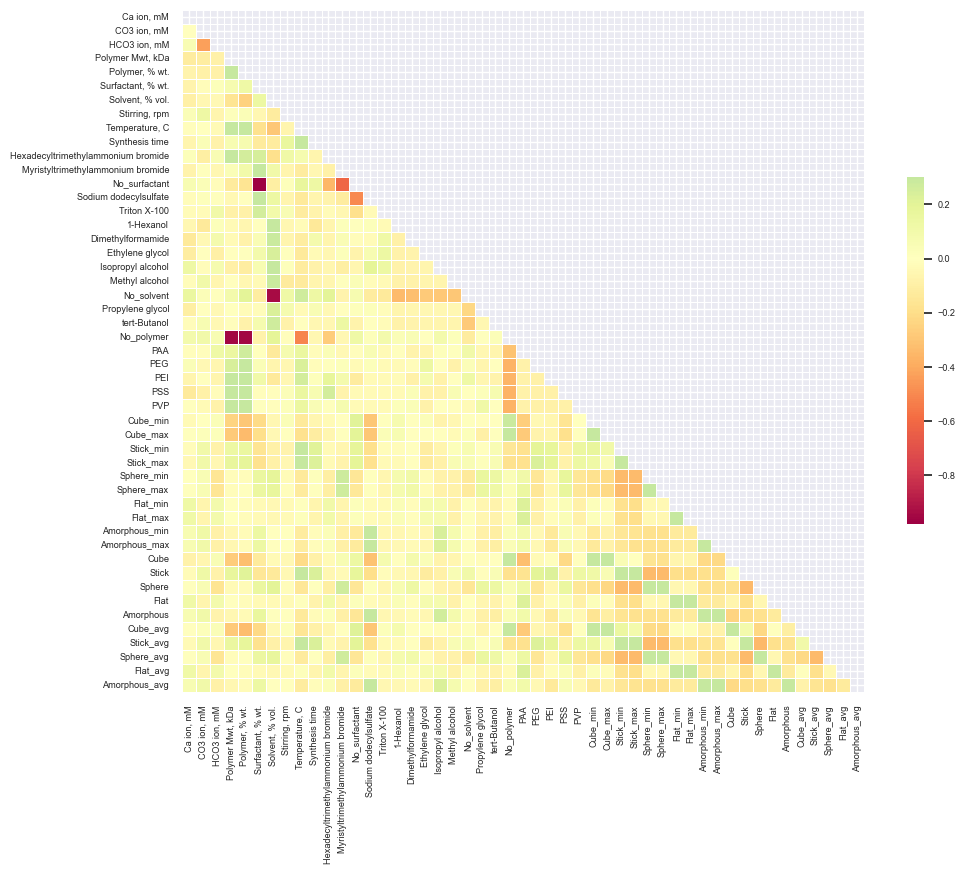

In [23]:
sns.set(font_scale=0.6)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='Spectral', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Scatterplot Matrix

In [24]:
scatterplot_data = pd.concat([df.iloc[:,:10], df[['Stick', 'Sphere', 'Cube', 'Flat', 'Amorphous']]], axis=1)

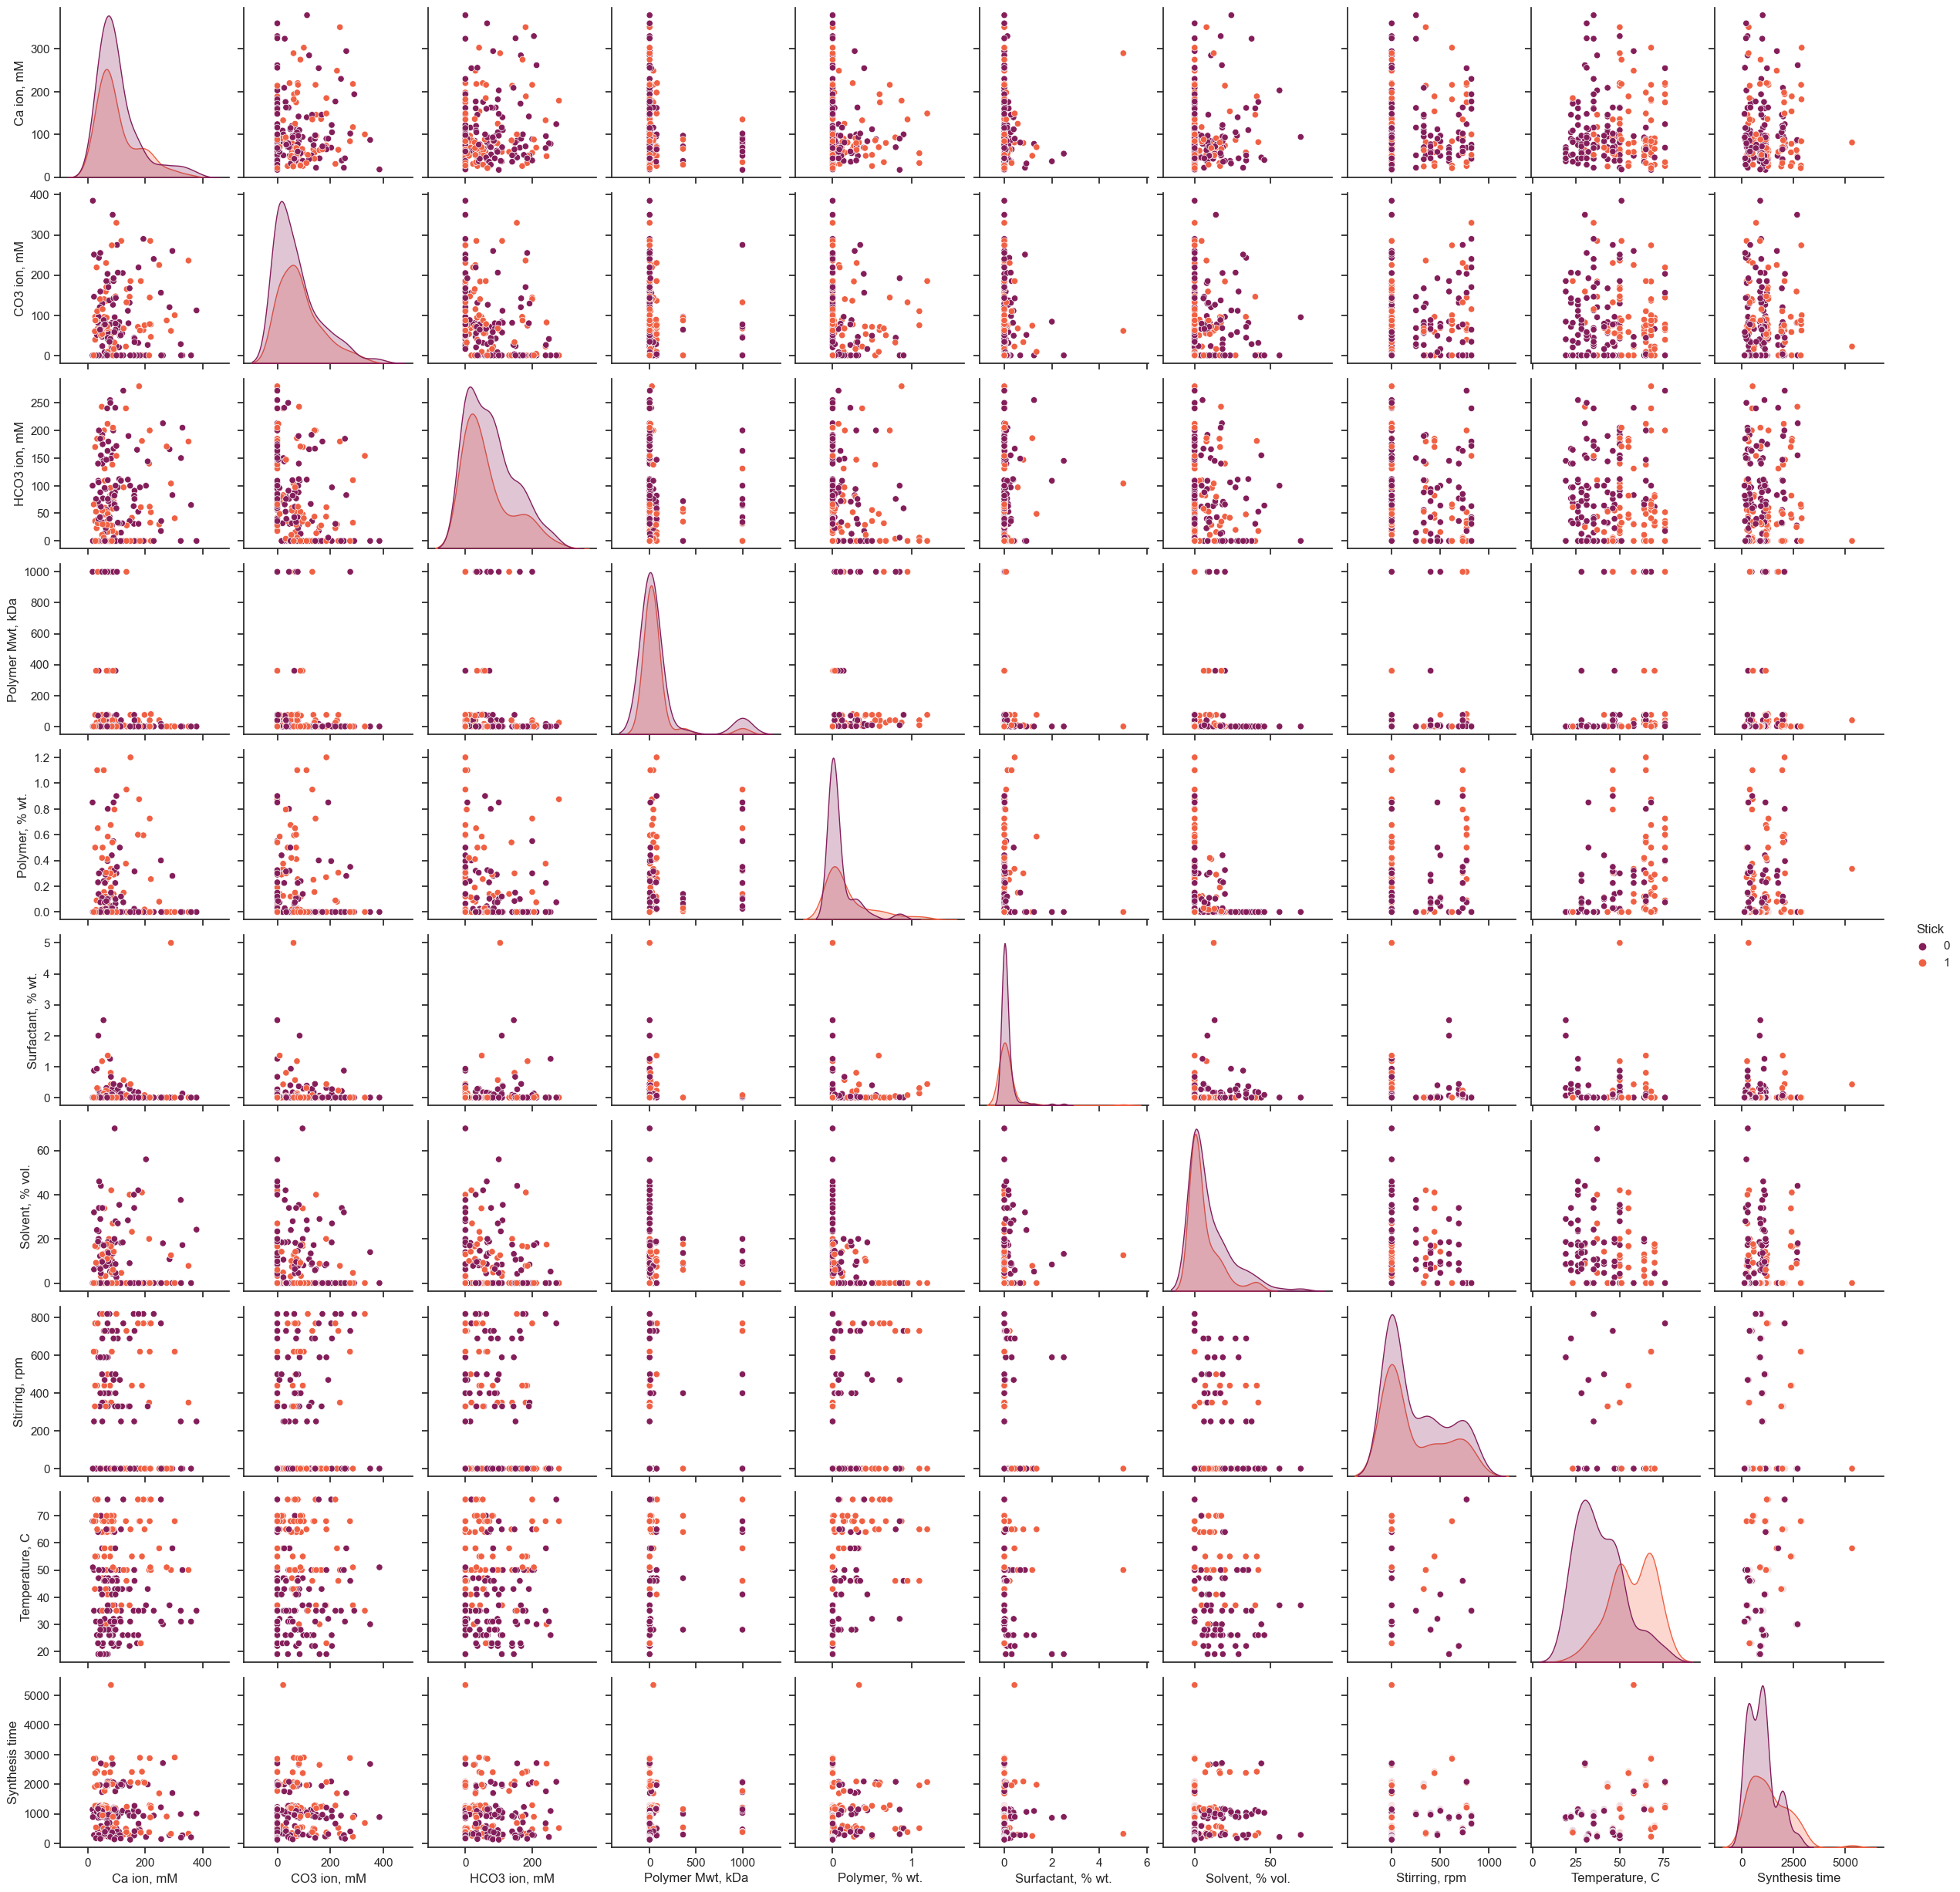

In [25]:
sns.set_theme(style="ticks")
sns.pairplot(scatterplot_data.drop(columns=['Sphere', 'Cube', 'Flat', 'Amorphous']), hue="Stick", palette='rocket')

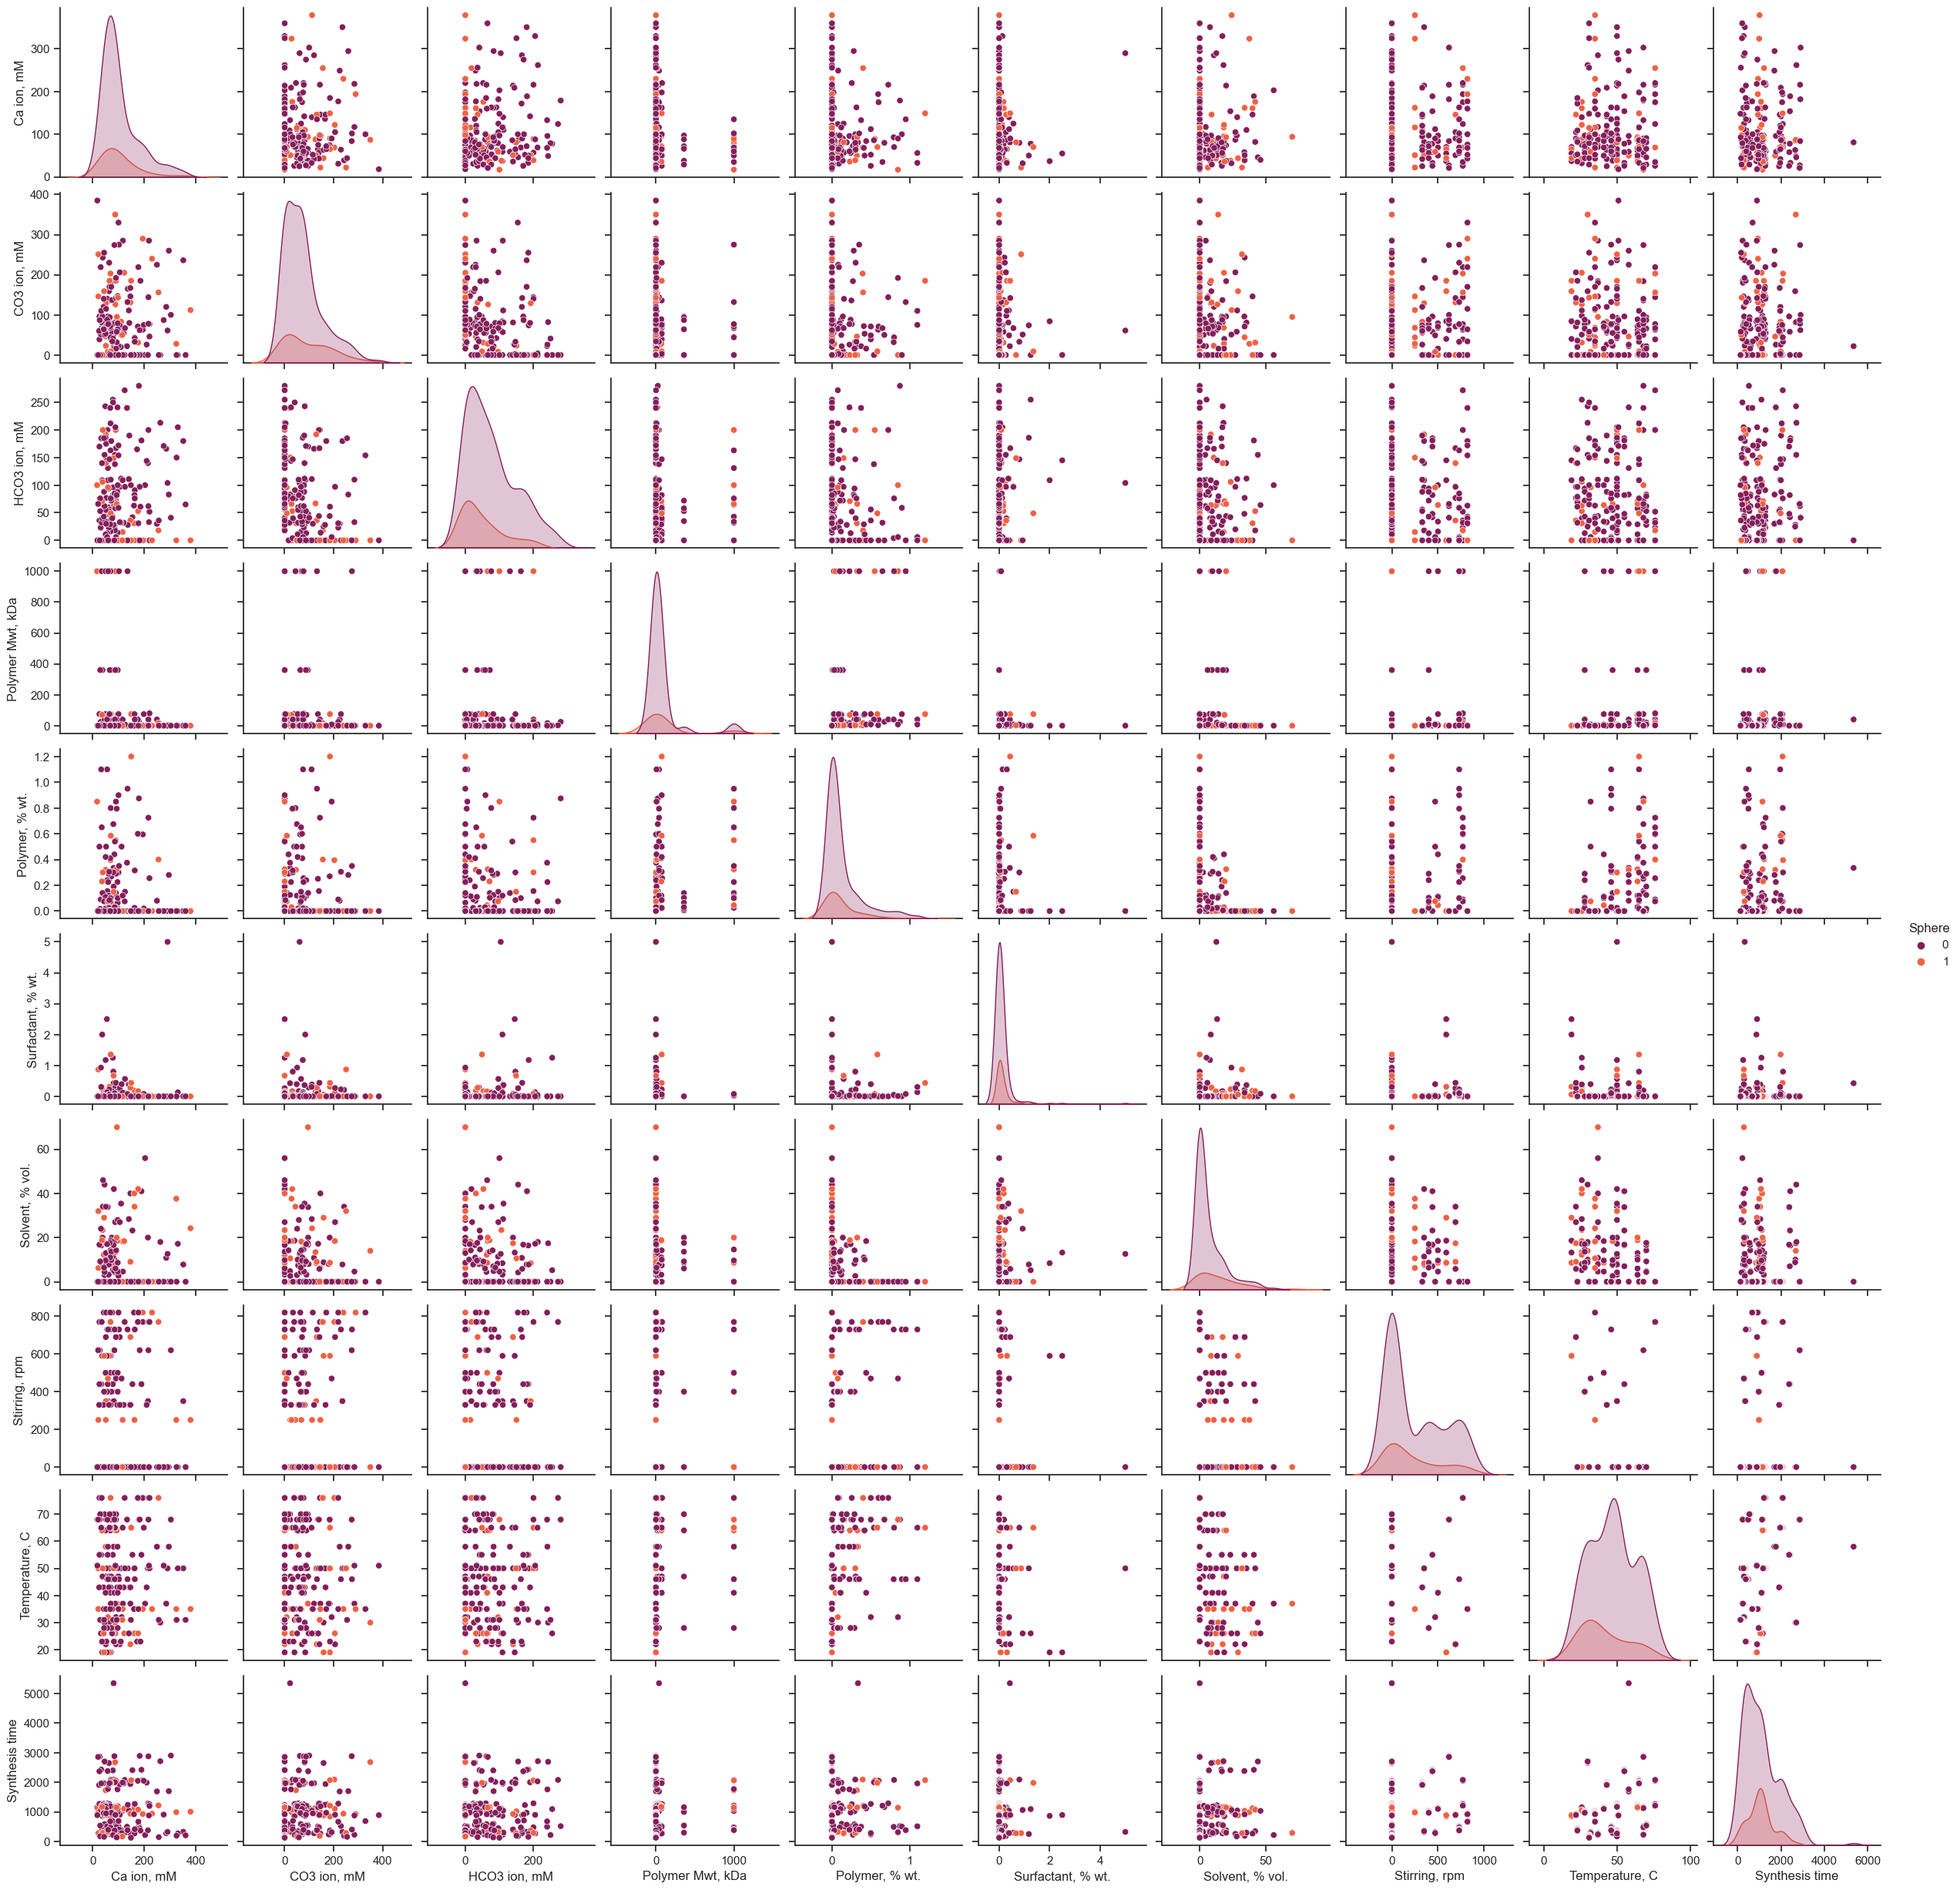

In [26]:
sns.set_theme(style="ticks")
sns.pairplot(scatterplot_data.drop(columns=['Stick', 'Cube', 'Flat', 'Amorphous']), hue="Sphere", palette='rocket')

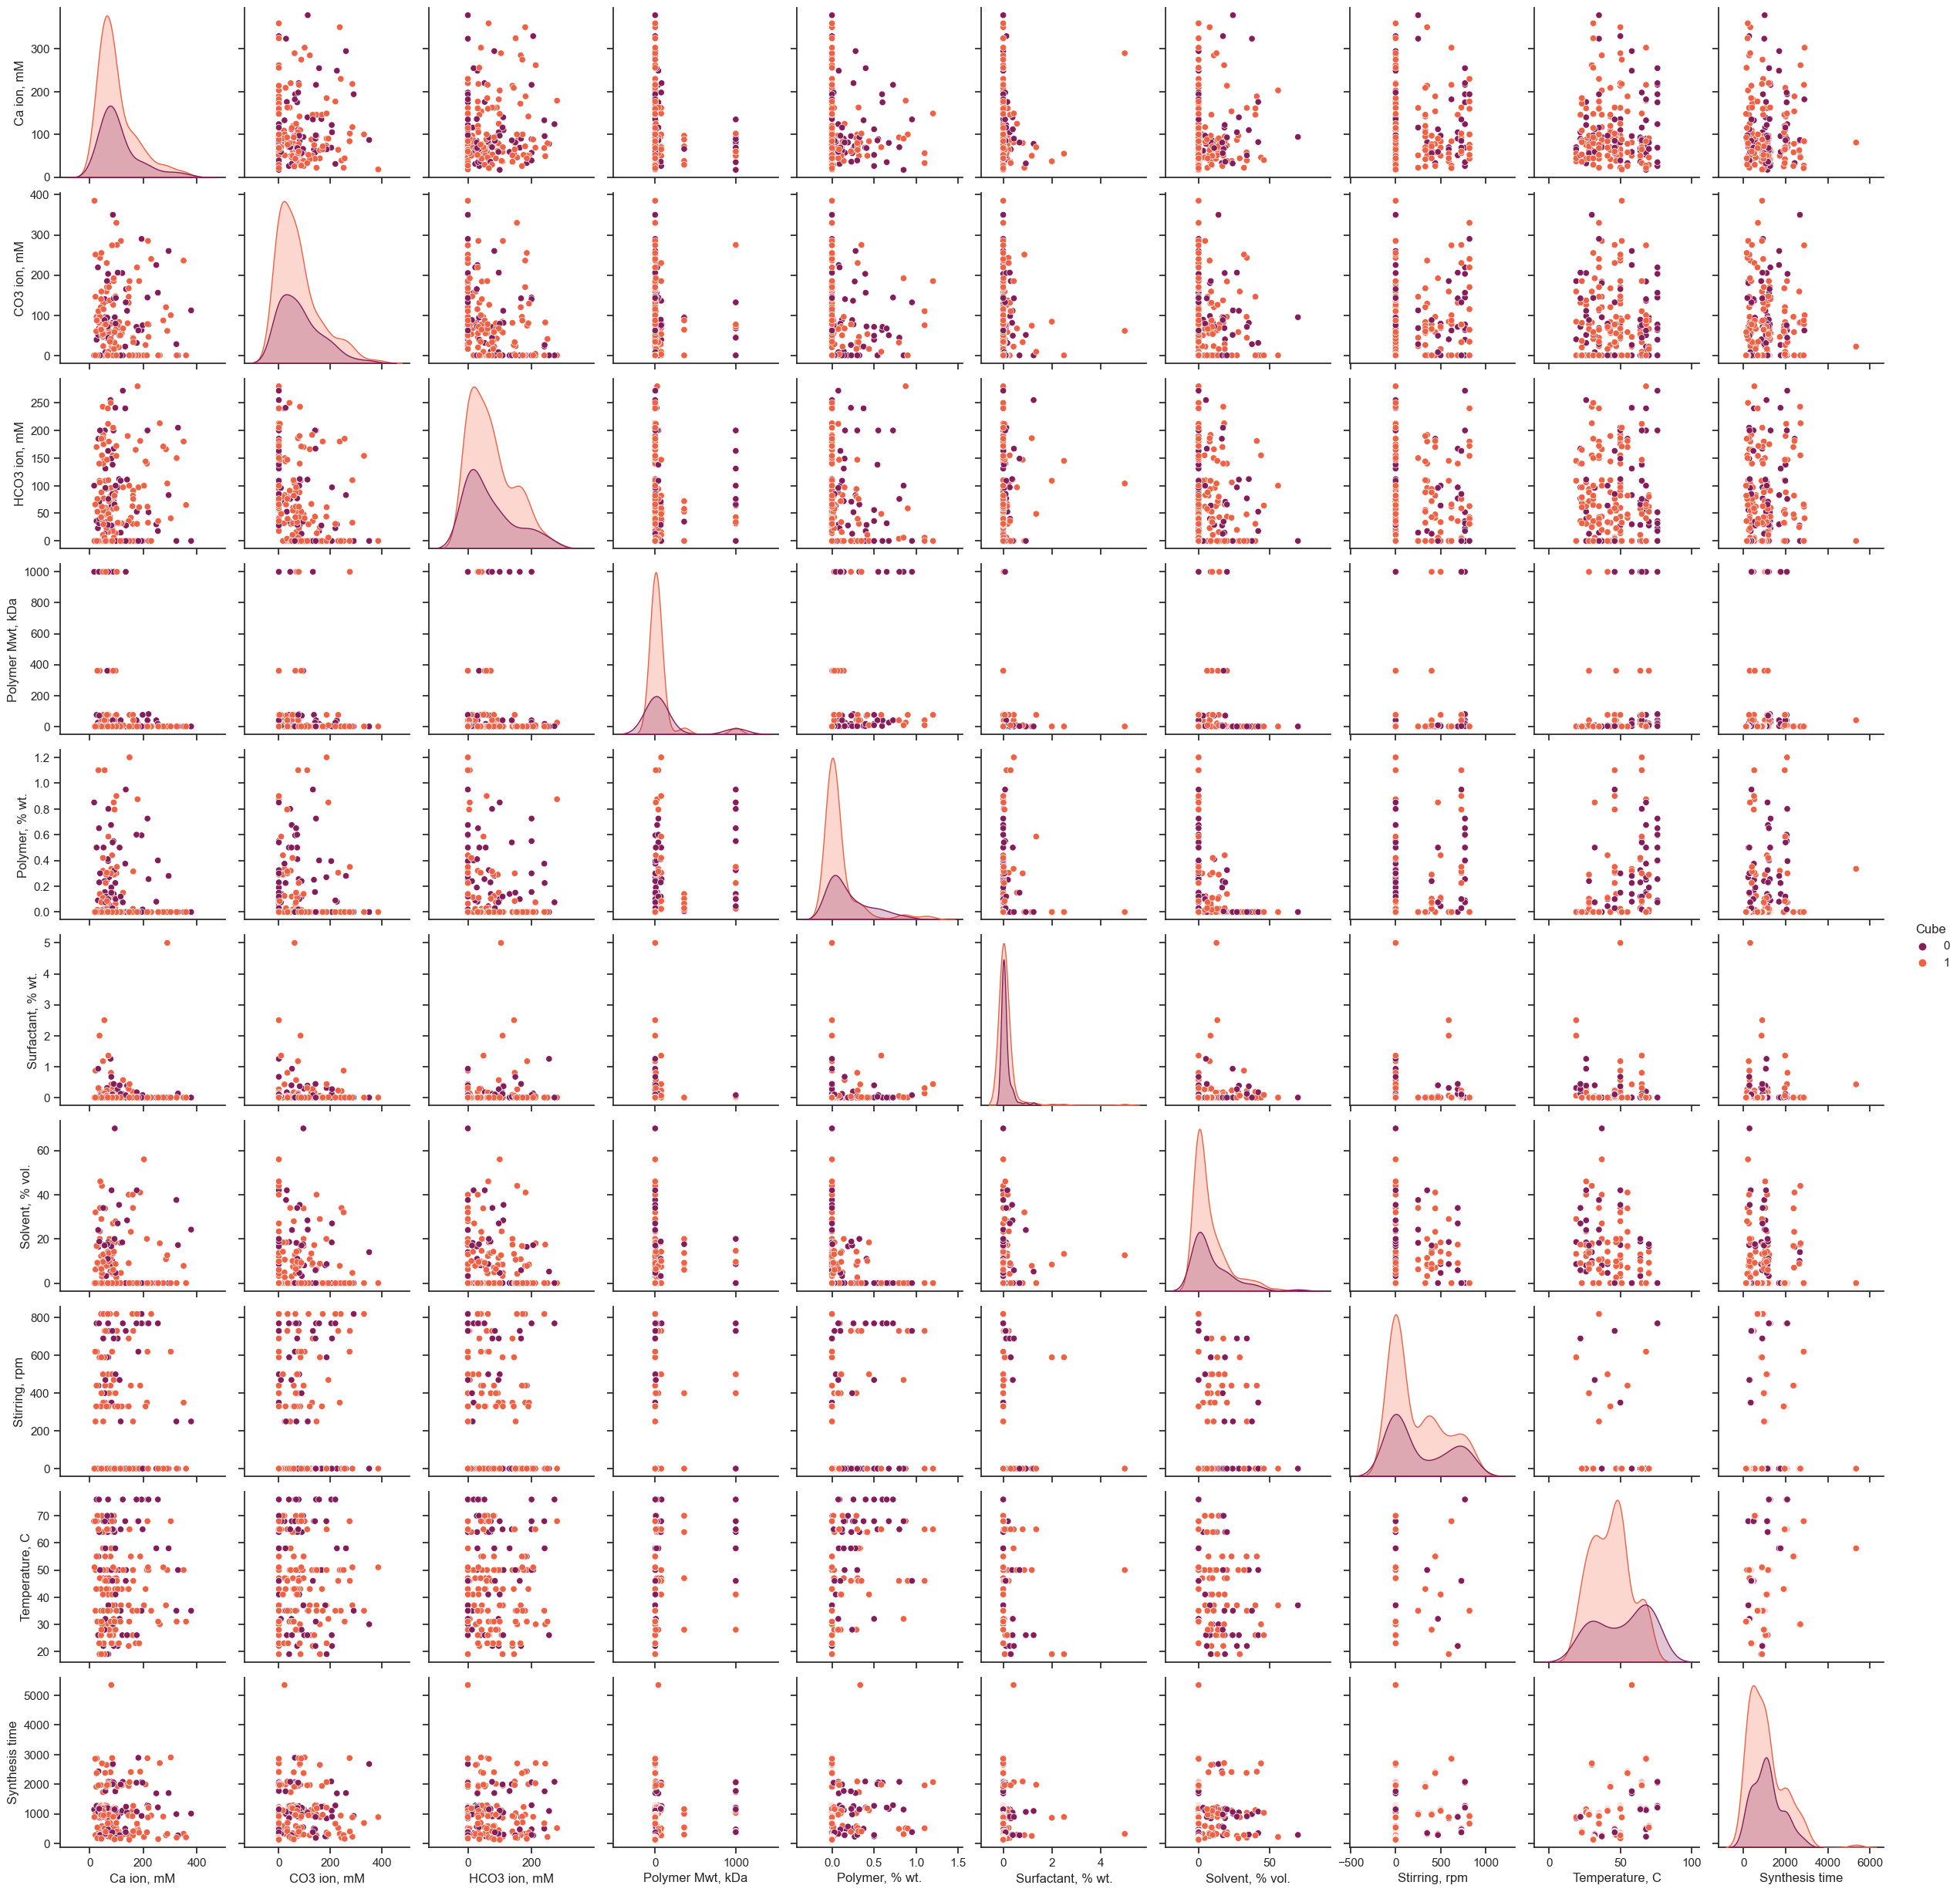

In [27]:
sns.set_theme(style="ticks")
sns.pairplot(scatterplot_data.drop(columns=['Sphere', 'Stick', 'Flat', 'Amorphous']), hue="Cube", palette='rocket')

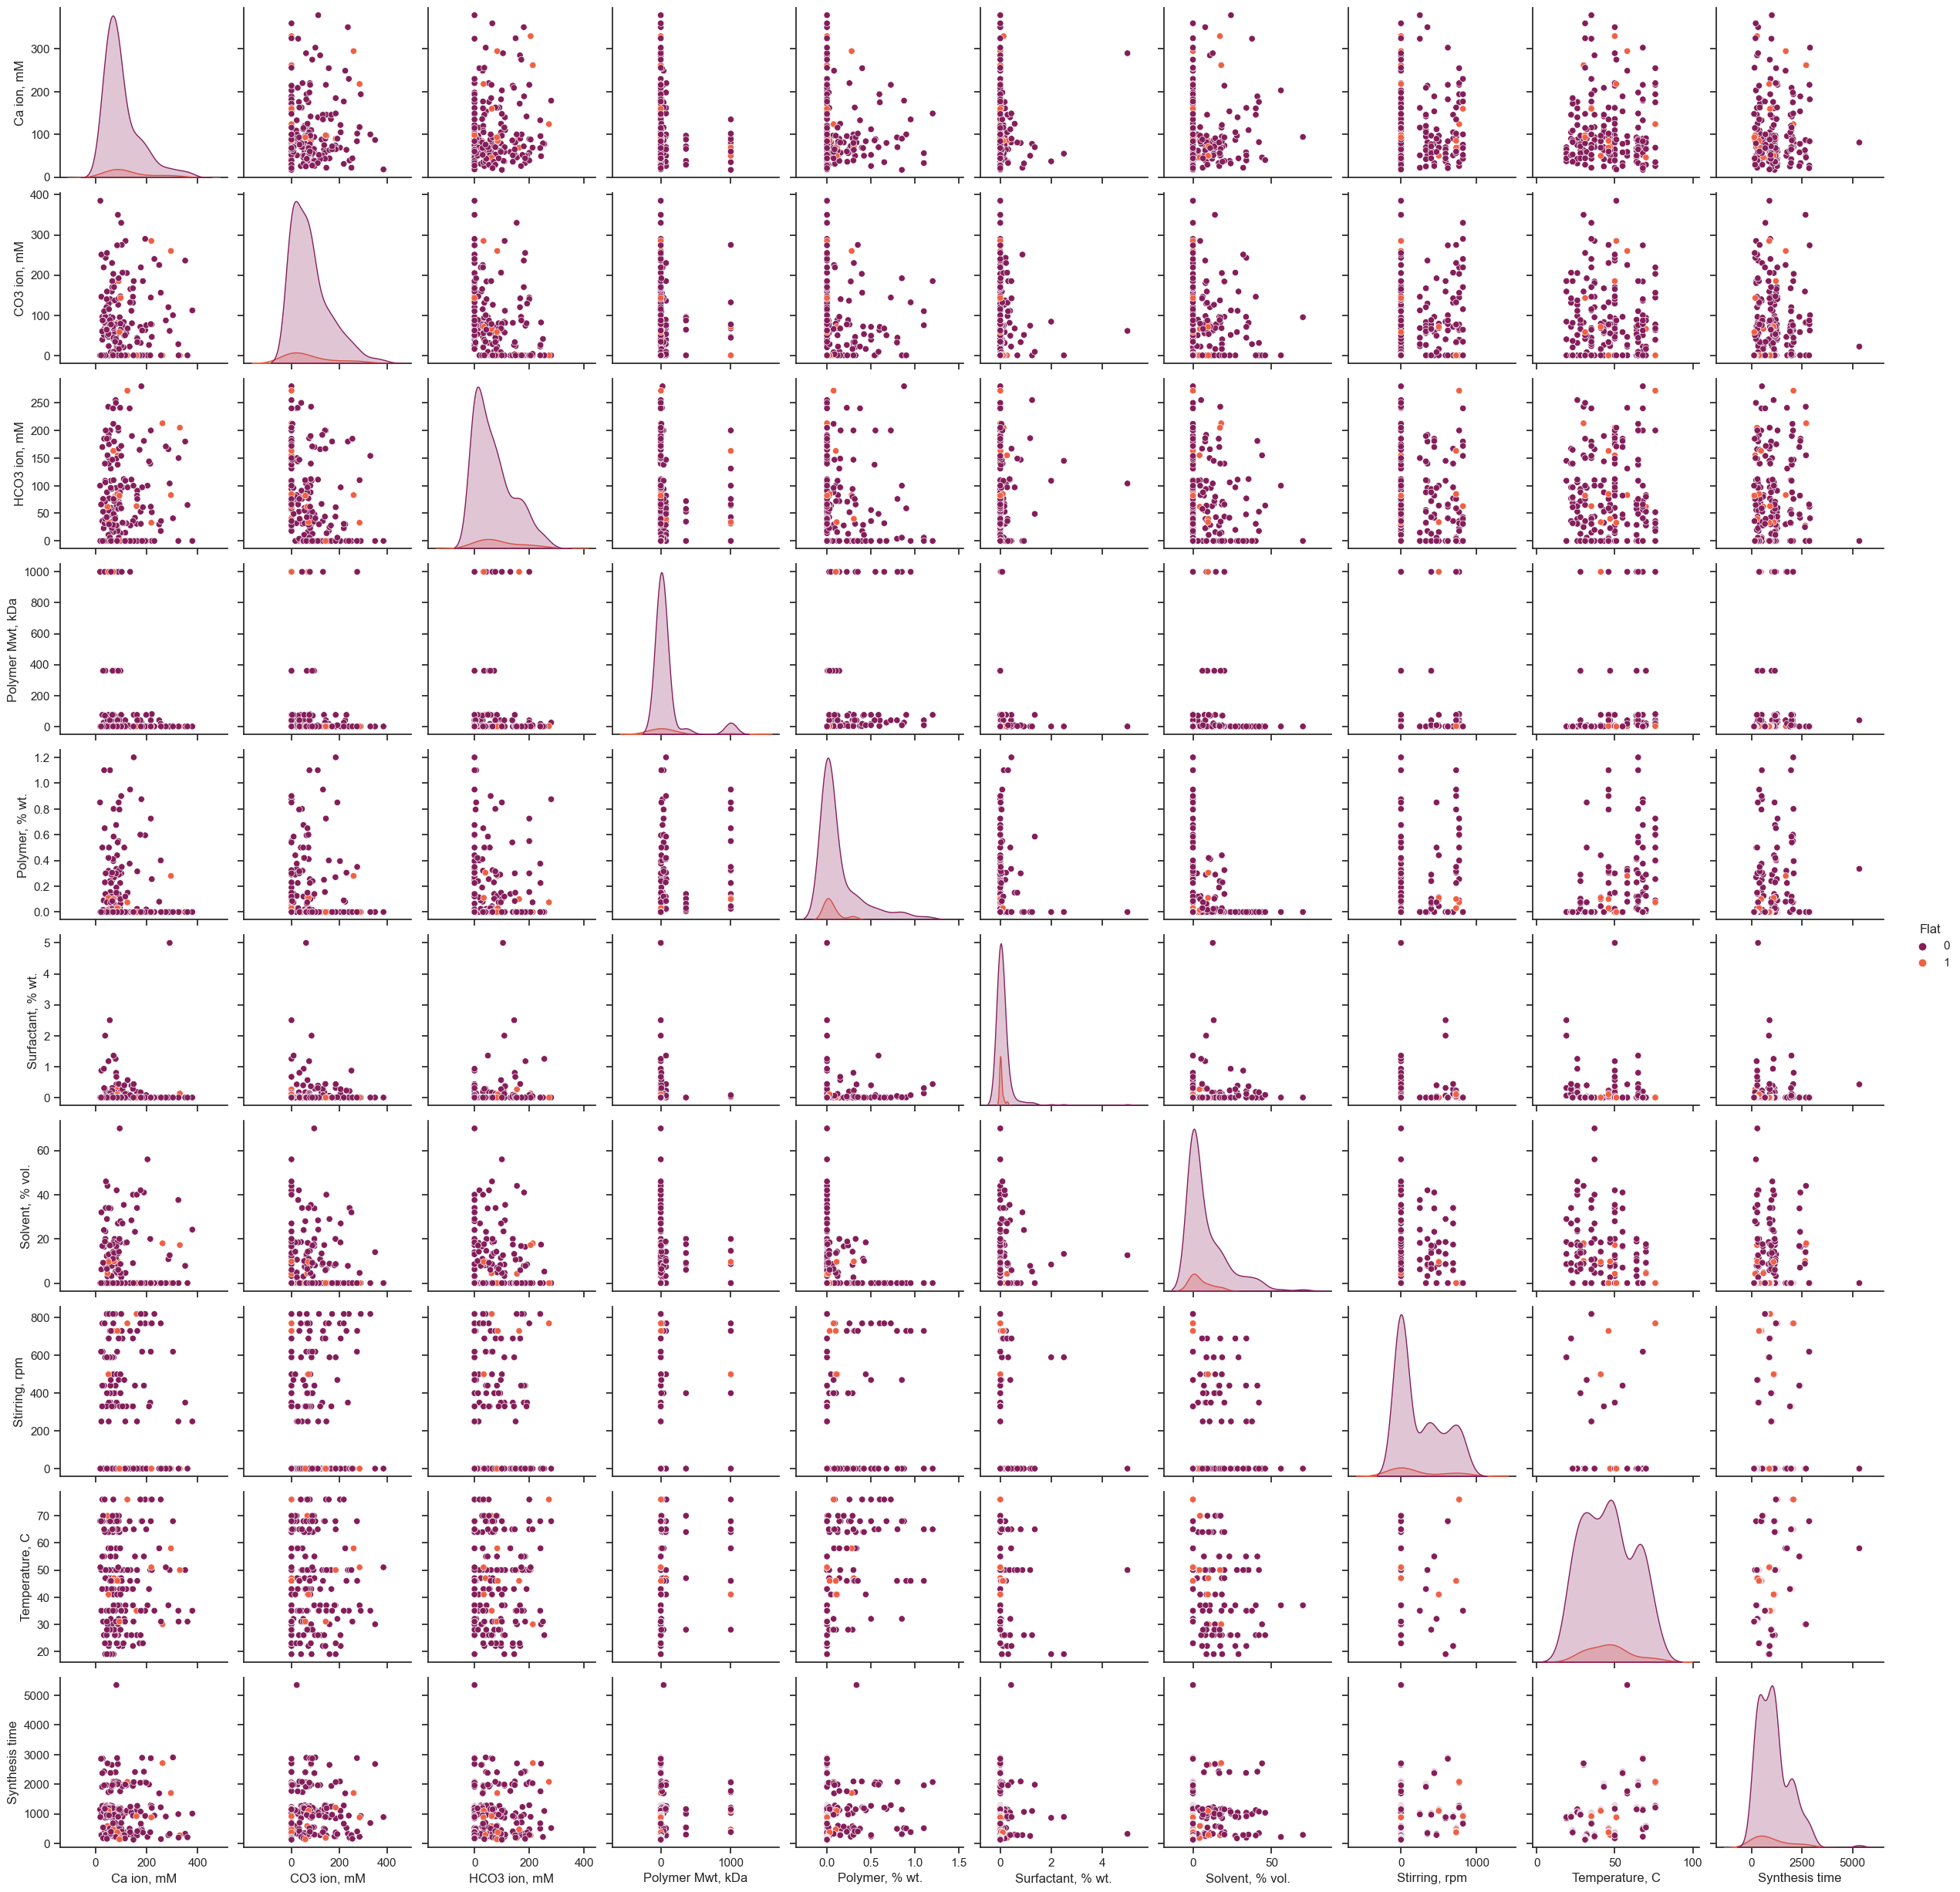

In [28]:
sns.set_theme(style="ticks")
sns.pairplot(scatterplot_data.drop(columns=['Sphere', 'Stick', 'Cube', 'Amorphous']), hue="Flat", palette='rocket')

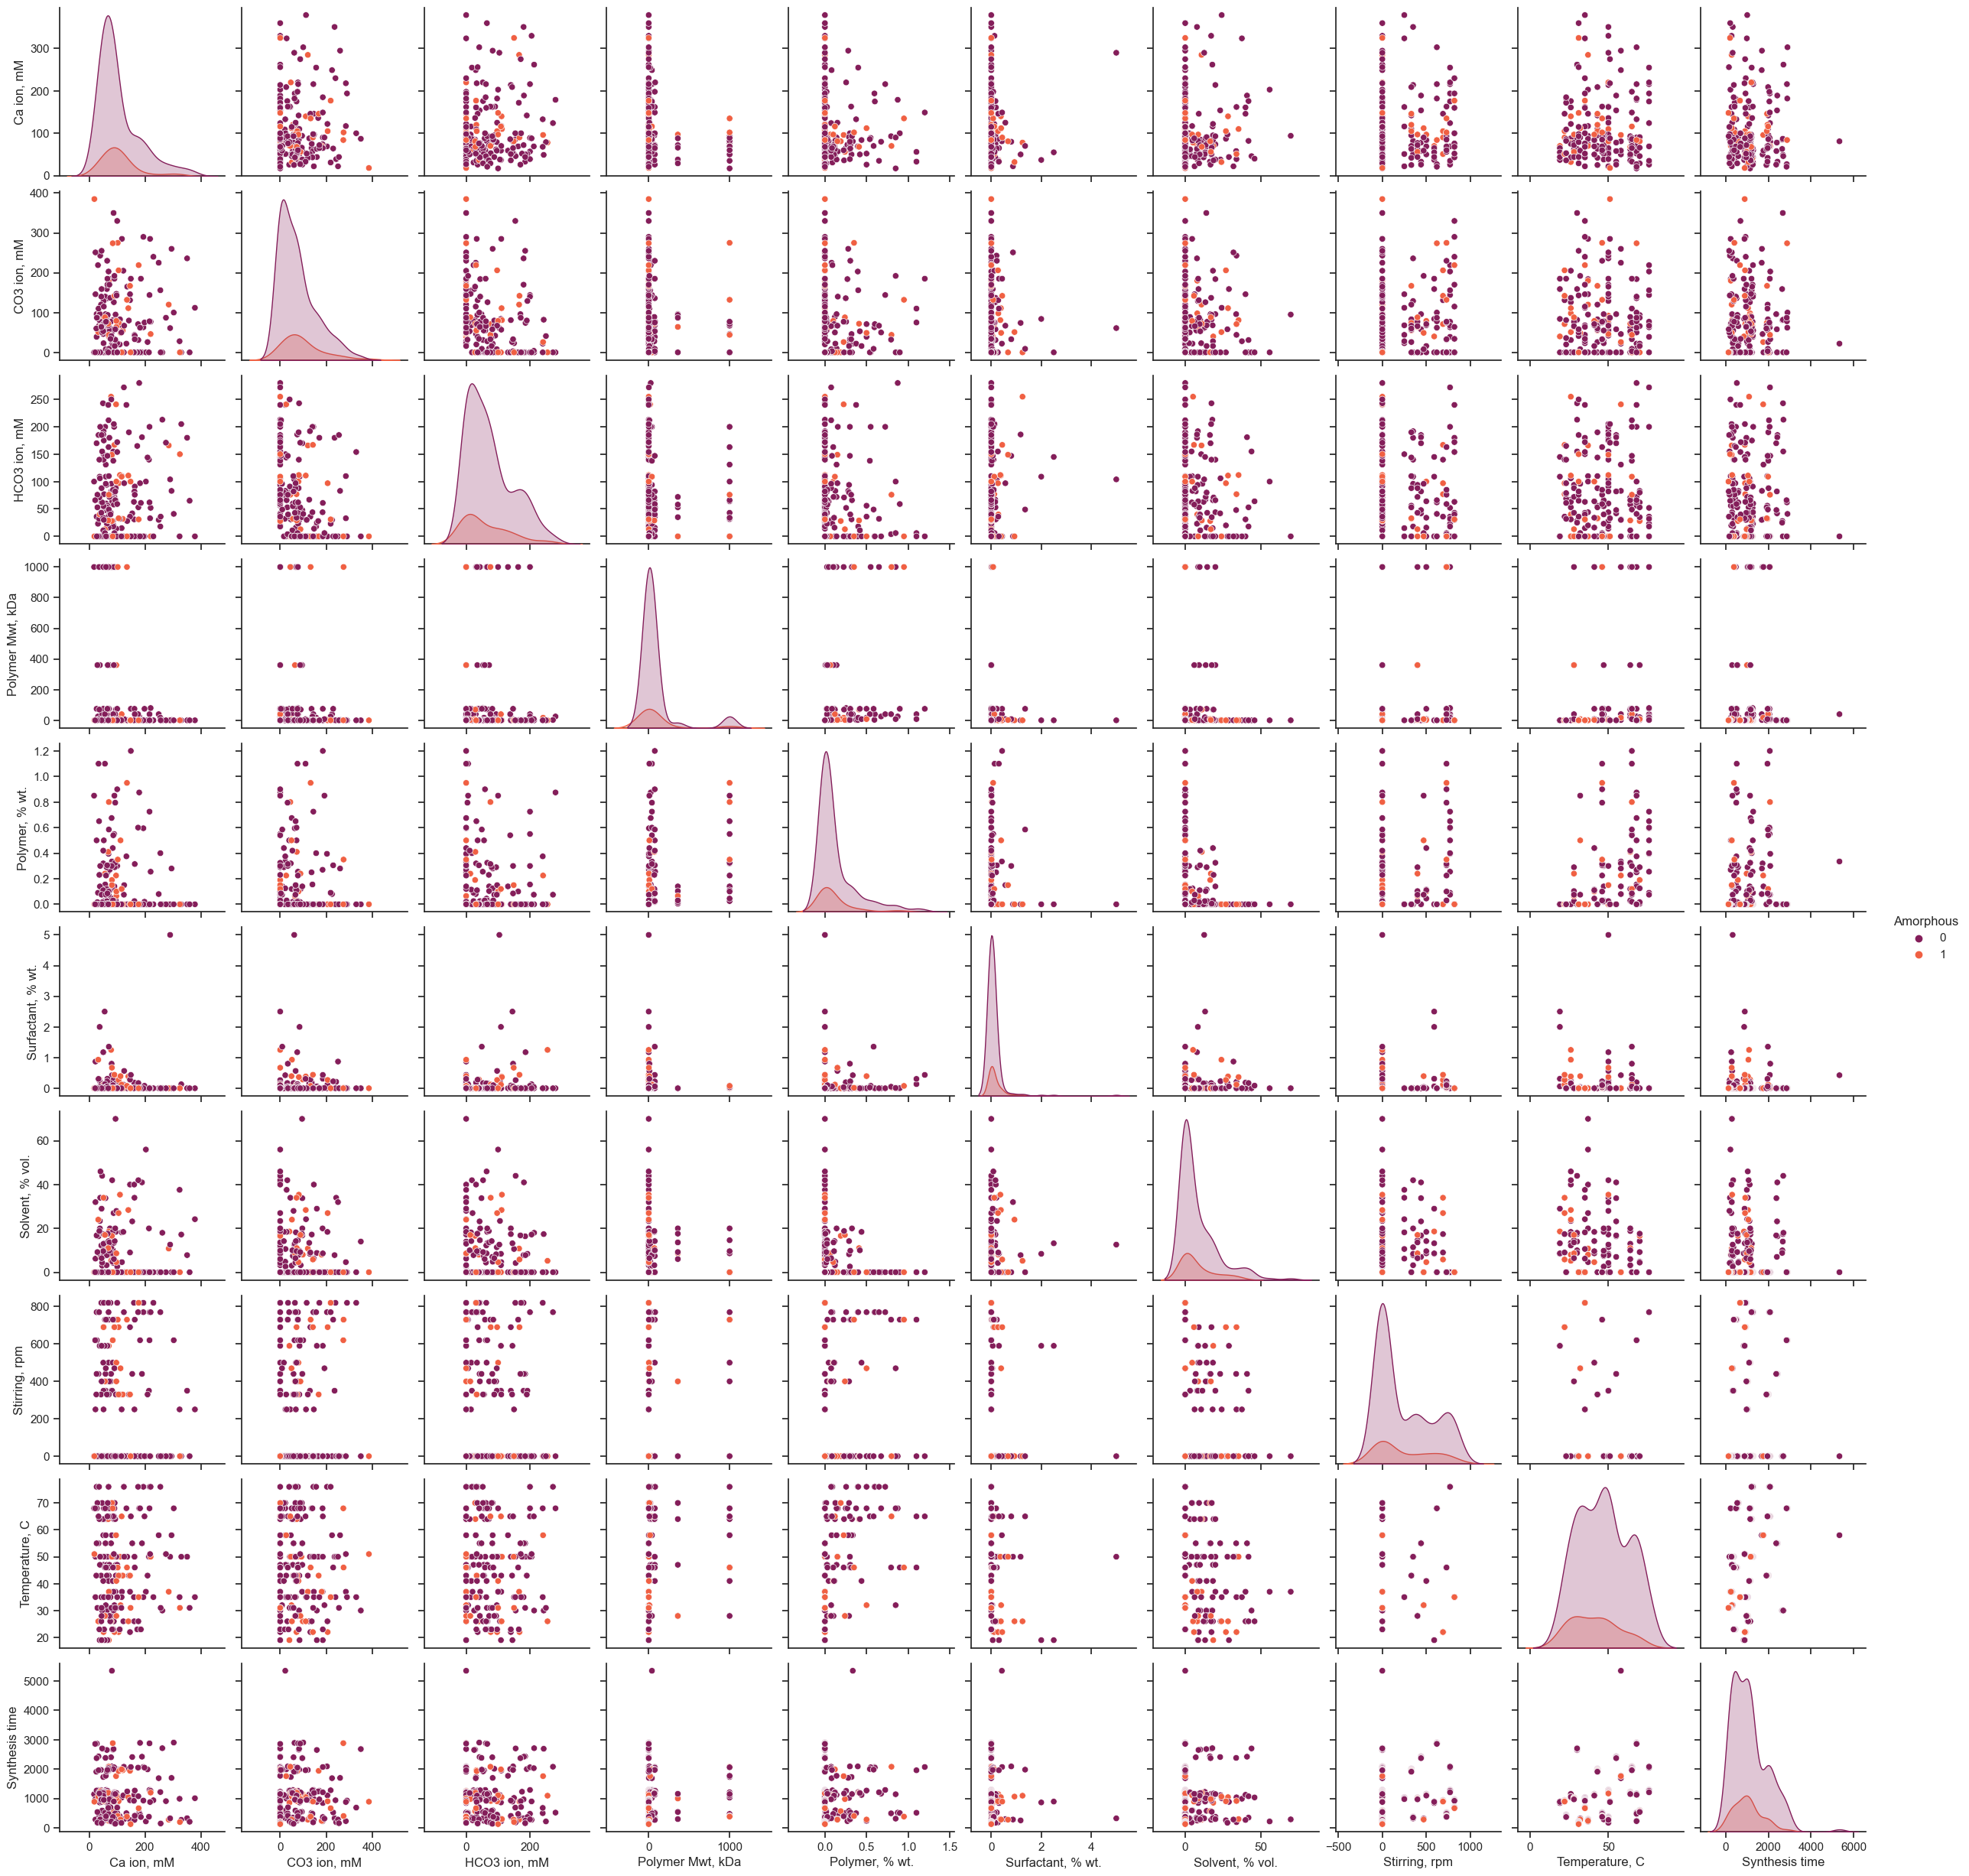

In [29]:
sns.set_theme(style="ticks")
sns.pairplot(scatterplot_data.drop(columns=['Sphere', 'Stick', 'Cube', 'Flat']), hue="Amorphous", palette='rocket')